# Loading Images Using tf.Data.Dataset

* Retrieve Images using `tf.keras.utils.get_file`
* Load Images using Keras Pre-Processing `tf.keras.preprocessing.image.ImageDataGenerator` (Note: it's slow and not well integrated with the rest of TensorFlow)
* Load Images using `tf.Data.Dataset`
* Basic Methods for Training

## Setup

In [1]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
print("TensorFlow version: ",tf.version.VERSION)

TensorFlow version:  2.4.1


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Retrieve the images

The dataset used in this example is distributed as directories of images, with 5 sub-directories and one class of image per directory.

In [3]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['sunflowers', 'daisy', 'roses', 'tulips', 'dandelion'],
      dtype='<U10')

Verify data... Here are some roses:

In [8]:
list(data_dir.glob('roses/*'))[0]

PosixPath('/home/jupyter/.keras/datasets/flower_photos/roses/8523394349_61b31fdd8f_m.jpg')

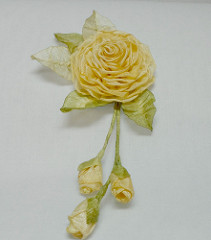

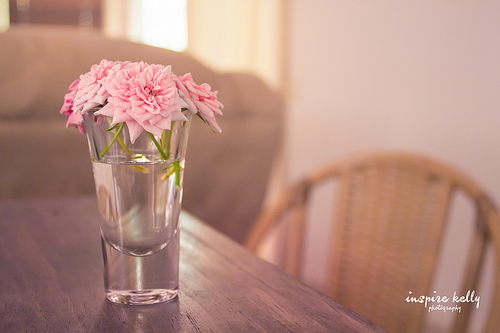

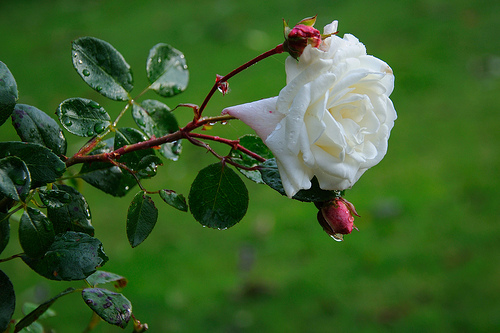

In [10]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

## Load using `keras.preprocessing`

A simple way to load images is to use `tf.keras.preprocessing`.

In [12]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

Define some parameters for the loader:

In [14]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [15]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


Inspect a batch for image processing:

In [22]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

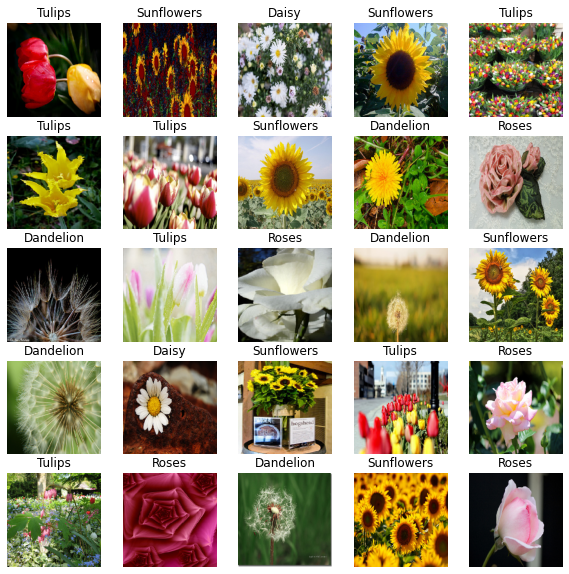

In [23]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has three downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [24]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [25]:
for f in list_ds.take(5):
    print(f.numpy())

b'/home/jupyter/.keras/datasets/flower_photos/dandelion/20165867412_fc45d31698_m.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/sunflowers/5069564563_ae03792c3c_m.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/daisy/2646438199_b309cffd65_n.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/tulips/8713392604_90631fb809_n.jpg'
b'/home/jupyter/.keras/datasets/flower_photos/tulips/466409031_4c10294db5_m.jpg'


Short pure-tensorflow function that converts a file path to an `(img, label)` pair:

In [26]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

In [27]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [28]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [32]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False]


## Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

Adding these features using the `tf.data` api.

In [33]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
            
    # Shuffle
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    # Repeat forever
    ds = ds.repeat()
    
    # Batch
    ds = ds.batch(BATCH_SIZE)
    
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [34]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

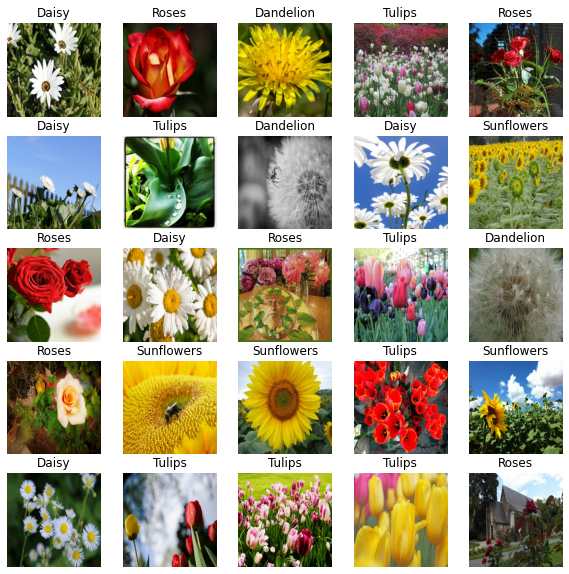

In [35]:
show_batch(image_batch.numpy(), label_batch.numpy())